In [40]:
#Import the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
df = pd.read_csv('/content/pcos_dataset.csv')
df.head()

,Age,BMI,Menstrual_Irregularity,Testosterone_Level(ng/dL),Antral_Follicle_Count,PCOS_Diagnosis
0,24,34.7,1,25.2,20,0
1,37,26.4,0,57.1,25,0
2,32,23.6,0,92.7,28,0
3,28,28.8,0,63.1,26,0
4,25,22.1,1,59.8,8,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Age                        1000 non-null   int64  
 1   BMI                        1000 non-null   float64
 2   Menstrual_Irregularity     1000 non-null   int64  
 3   Testosterone_Level(ng/dL)  1000 non-null   float64
 4   Antral_Follicle_Count      1000 non-null   int64  
 5   PCOS_Diagnosis             1000 non-null   int64  
dtypes: float64(2), int64(4)
memory usage: 47.0 KB


In [4]:
df.isnull().sum()

,0
Age,0
BMI,0
Menstrual_Irregularity,0
Testosterone_Level(ng/dL),0
Antral_Follicle_Count,0
PCOS_Diagnosis,0


In [5]:
df["PCOS_Diagnosis"].value_counts()

,count
PCOS_Diagnosis,
0,801
1,199


In [6]:
df.columns

Index(['Age', 'BMI', 'Menstrual_Irregularity', 'Testosterone_Level(ng/dL)',
       'Antral_Follicle_Count', 'PCOS_Diagnosis'],
      dtype='object')

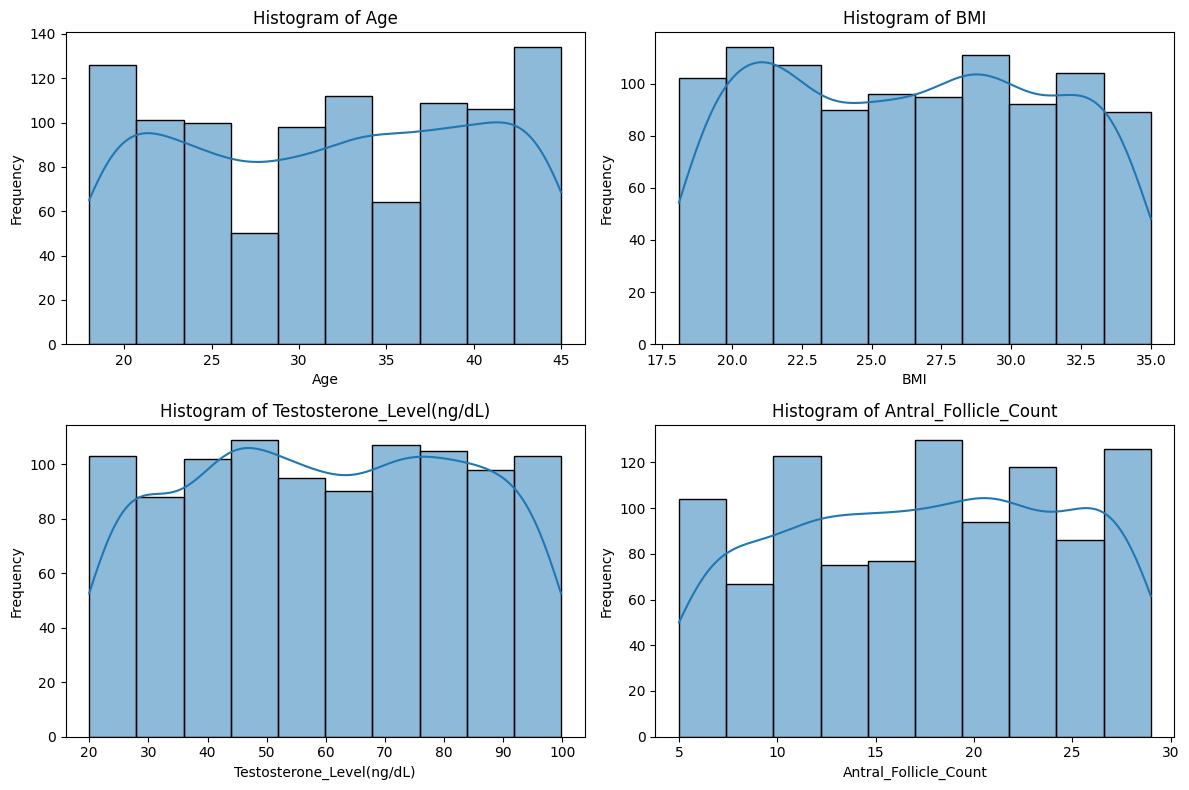

In [7]:
# Define continuous variables
continuous = ['Age', 'BMI', 'Testosterone_Level(ng/dL)', 'Antral_Follicle_Count']
# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()
# Plot histograms
for i, var in enumerate(continuous):
    sns.histplot(df[var], bins=10, kde=True, ax=axes[i])
    axes[i].set_title(f'Histogram of {var}')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

<ipython-input-8-e1fe931f00d7>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[var], ax=axes[i], palette="pastel")
<ipython-input-8-e1fe931f00d7>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[var], ax=axes[i], palette="pastel")


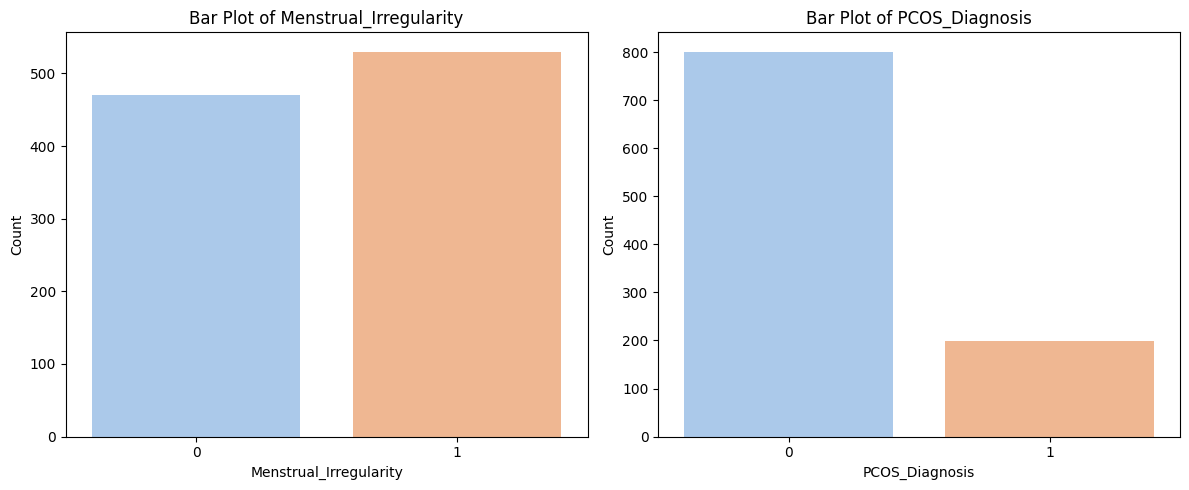

In [8]:
categorical = ['Menstrual_Irregularity', 'PCOS_Diagnosis']
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
# Plot bar plots
for i, var in enumerate(categorical):
    sns.countplot(x=df[var], ax=axes[i], palette="pastel")
    axes[i].set_title(f'Bar Plot of {var}')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Count')

plt.tight_layout()
plt.show()

<ipython-input-9-7c2f286cc9b4>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[target], y=df[var], ax=axes[i], palette="pastel")
<ipython-input-9-7c2f286cc9b4>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[target], y=df[var], ax=axes[i], palette="pastel")
<ipython-input-9-7c2f286cc9b4>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[target], y=df[var], ax=axes[i], palette="pastel")
<ipython-input-9-7c2f286cc9b4>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Ass

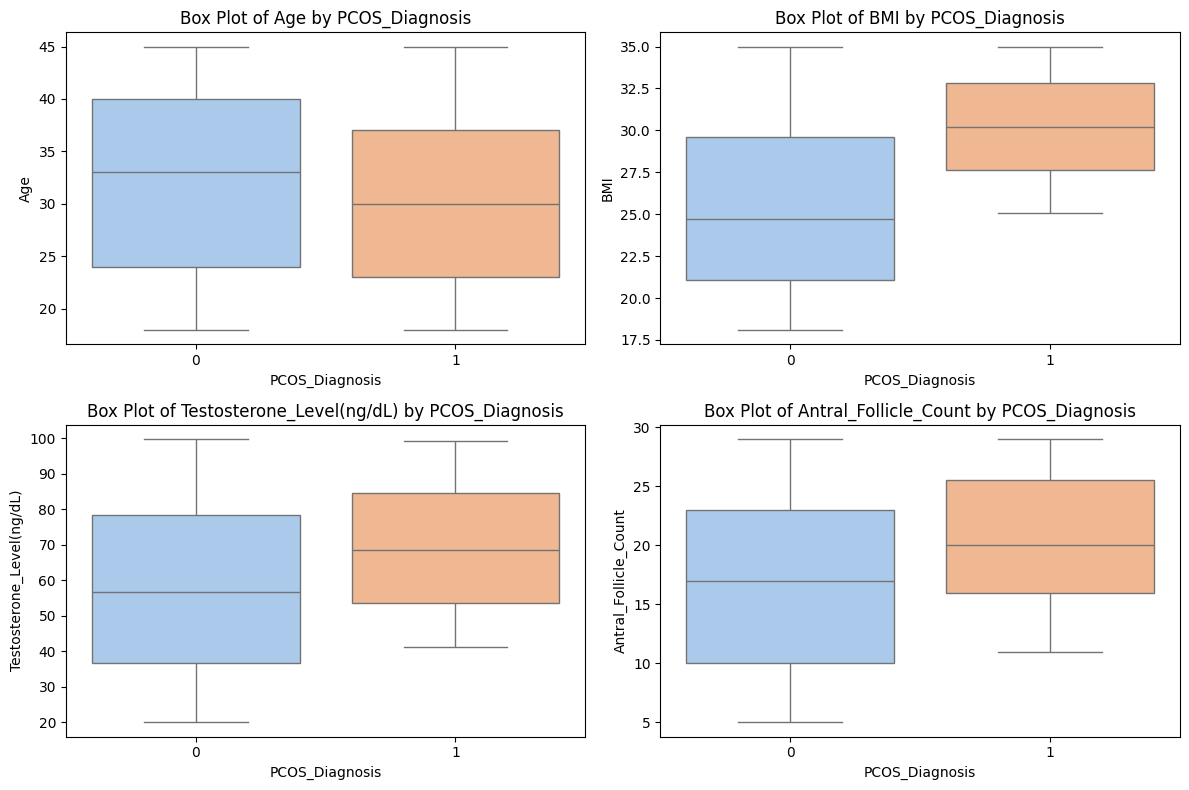

In [9]:
target = 'PCOS_Diagnosis'
# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()
# Plot boxplots
for i, var in enumerate(continuous):
    sns.boxplot(x=df[target], y=df[var], ax=axes[i], palette="pastel")
    axes[i].set_title(f'Box Plot of {var} by {target}')
    axes[i].set_xlabel(target)
    axes[i].set_ylabel(var)
plt.tight_layout()
plt.show()

In [13]:
X = df[['Age', 'BMI', 'Menstrual_Irregularity', 'Testosterone_Level(ng/dL)', 'Antral_Follicle_Count']]
y = df["PCOS_Diagnosis"]
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

**XGBOOST CLASSIFIER**

In [14]:
# Define XGBoost model
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
# Define SMOTE and XGBoost as a pipeline
smote_xgb_pipeline = Pipeline([
    ('smote', SMOTE(sampling_strategy='auto', random_state=42)),
    ('xgb', xgb_clf)
])
# Define hyperparameter grid
param_grid = {
    'xgb__n_estimators': [100, 300],
    'xgb__max_depth': [3, 5],
    'xgb__learning_rate': [0.01, 0.1],
    'xgb__subsample': [0.7, 1.0],
    'xgb__colsample_bytree': [0.7, 1.0],
    'xgb__gamma': [0, 0.1],
    'xgb__reg_lambda': [1, 10]
}
# Perform Grid Search with 10-fold CV
grid_search = GridSearchCV(smote_xgb_pipeline, param_grid, scoring='accuracy', cv=10, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 128 candidates, totalling 1280 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:00:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=42)),
                                       ('xgb',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric='logloss',
                                                      feature_types=None,
                                                      gamma=None,
                                                      grow_policy=None,
                                                      importa...
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=42, ...))]),
             n_jobs=-1,
             param_grid={'xgb__colsample_bytree': [0.7, 1.0],
                         'xgb__gamma': [0, 0.1],
                         'xgb__learning_rate': [0.01, 0.1],
                         'xgb__max_depth': [3, 5],
                         'xgb__n_estimators': [100, 300],
                         'xgb__reg_lambda': [1, 10],
                         'xgb__subsample': [0.7, 1.0]},
             scoring='accuracy', verbose=2)

In [15]:
# Get best parameters
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'xgb__colsample_bytree': 1.0, 'xgb__gamma': 0, 'xgb__learning_rate': 0.01, 'xgb__max_depth': 3, 'xgb__n_estimators': 300, 'xgb__reg_lambda': 10, 'xgb__subsample': 0.7}


In [19]:
# Evaluate on test set
best_xgb = grid_search.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_xgb)
print("Test Accuracy:", accuracy)

Test Accuracy: 1.0


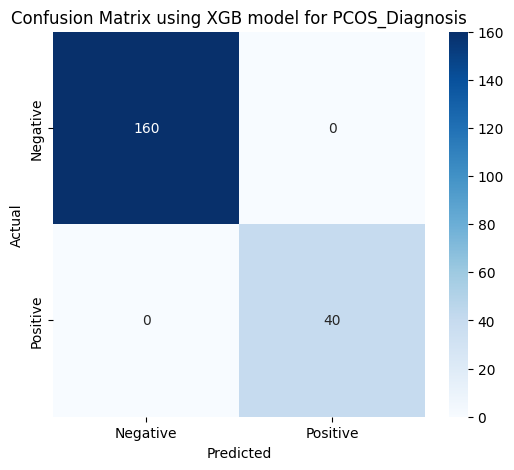

In [20]:
cm = confusion_matrix(y_test, y_pred_xgb)
# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix using XGB model for PCOS_Diagnosis")
plt.show()

In [39]:
print("XGBoost Classification Report:\n", classification_report(y_test, y_pred_xgb))

XGBoost Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       160
           1       1.00      1.00      1.00        40

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



**RANDOM FOREST CLASSIFIER**

In [23]:
# Define Random Forest model
rf_clf = RandomForestClassifier(random_state=42)
# Define SMOTE and Random Forest as a pipeline
smote_rf_pipeline = Pipeline([
    ('smote', SMOTE(sampling_strategy='auto', random_state=42)),
    ('rf', rf_clf)
])
# Define hyperparameter grid
param_grid = {
    'rf__n_estimators': [100, 150, 200, 250],  # Number of trees
    'rf__max_depth': [3, 5, 8, 10, 15],  # Maximum depth of trees
    'rf__min_samples_split': [2, 5, 10],  # Minimum samples to split a node
}
# Perform Grid Search with 10-fold CV
grid_search = GridSearchCV(smote_rf_pipeline, param_grid, scoring='accuracy', cv=10, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 60 candidates, totalling 600 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=42)),
                                       ('rf',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'rf__max_depth': [3, 5, 8, 10, 15],
                         'rf__min_samples_split': [2, 5, 10],
                         'rf__n_estimators': [100, 150, 200, 250]},
             scoring='accuracy', verbose=2)

In [24]:
# Get best parameters
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'rf__max_depth': 3, 'rf__min_samples_split': 2, 'rf__n_estimators': 100}


In [25]:
# Evaluate on test set
best_rf = grid_search.best_estimator_
y_pred_rf = best_rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_rf)
print("Test Accuracy:", accuracy)

Test Accuracy: 1.0


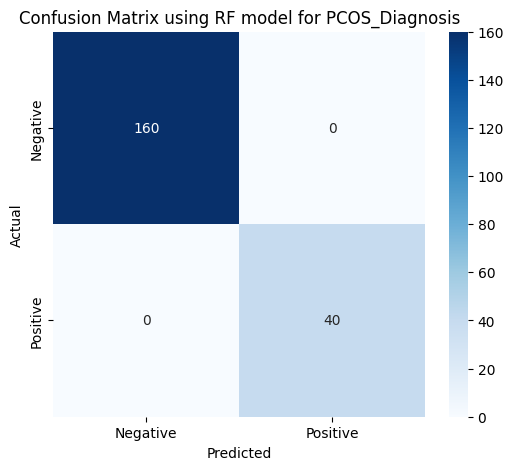

In [26]:
cm = confusion_matrix(y_test, y_pred_rf)
# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix using RF model for PCOS_Diagnosis")
plt.show()

In [38]:
print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf))

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       160
           1       1.00      1.00      1.00        40

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



**LIGHTGBM MODEL**

In [28]:
# Define LightGBM model
lgb_clf = lgb.LGBMClassifier(random_state=42)
# Define SMOTE and LightGBM as a pipeline
smote_lgb_pipeline = Pipeline([
    ('smote', SMOTE(sampling_strategy='auto', random_state=42)),
    ('lgb', lgb_clf)
])
# Define hyperparameter grid
param_grid = {
    'lgb__n_estimators': [100, 200, 300],  # Number of trees
    'lgb__max_depth': [3, 5, 8, -1],  # Maximum tree depth (-1 means no limit)
    'lgb__learning_rate': [0.001, 0.01, 0.1],  # Learning rate
    'lgb__num_leaves': [20, 31, 40],  # Number of leaves in one tree
}
# Perform Grid Search with 10-fold CV
grid_search = GridSearchCV(smote_lgb_pipeline, param_grid, scoring='accuracy', cv=10, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 108 candidates, totalling 1080 fits
[LightGBM] [Info] Number of positive: 641, number of negative: 641
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000135 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 565
[LightGBM] [Info] Number of data points in the train set: 1282, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=42)),
                                       ('lgb',
                                        LGBMClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'lgb__learning_rate': [0.001, 0.01, 0.1],
                         'lgb__max_depth': [3, 5, 8, -1],
                         'lgb__n_estimators': [100, 200, 300],
                         'lgb__num_leaves': [20, 31, 40]},
             scoring='accuracy', verbose=2)

In [29]:
# Get best parameters
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'lgb__learning_rate': 0.001, 'lgb__max_depth': 5, 'lgb__n_estimators': 100, 'lgb__num_leaves': 20}


In [30]:
# Evaluate on test set
best_lgb = grid_search.best_estimator_
y_pred_lgb = best_lgb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_lgb)
print("Test Accuracy:", accuracy)

Test Accuracy: 1.0


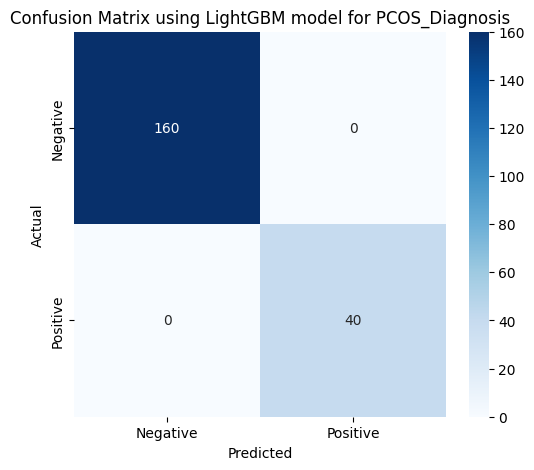

In [32]:
cm = confusion_matrix(y_test, y_pred_lgb)
# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix using LightGBM model for PCOS_Diagnosis")
plt.show()

In [37]:
print("Light-Boost Classification Report:\n", classification_report(y_test, y_pred_lgb))

Light-Boost Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       160
           1       1.00      1.00      1.00        40

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



In [33]:
# Define individual models
xgb_clf = xgb.XGBClassifier(n_estimators=200, eval_metric="logloss", random_state=42)
rf_clf = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)
lgb_clf = lgb.LGBMClassifier(n_estimators=200, learning_rate=0.1, num_leaves=31, random_state=42)
# Create an ensemble VotingClassifier
ensemble_clf = VotingClassifier(
    estimators=[('xgb', xgb_clf), ('rf', rf_clf), ('lgb', lgb_clf)],
    voting='soft'  # Soft voting to use probability estimates
)
# Train the ensemble model
ensemble_clf.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 159, number of negative: 641
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 450
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.198750 -> initscore=-1.394125
[LightGBM] [Info] Start training from score -1.394125
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='logloss',
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learni...
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...)),
                             ('rf',
                              RandomForestClassifier(max_depth=10,
                                                     n_estimators=200,
                                                     random_state=42)),
                             ('lgb',
                              LGBMClassifier(n_estimators=200,
                                             random_state=42))],
                 voting='soft')

In [34]:
# Predict on test set
y_pred_en = ensemble_clf.predict(X_test)
# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred_en)
print("Ensemble Model Test Accuracy:", accuracy)

Ensemble Model Test Accuracy: 1.0


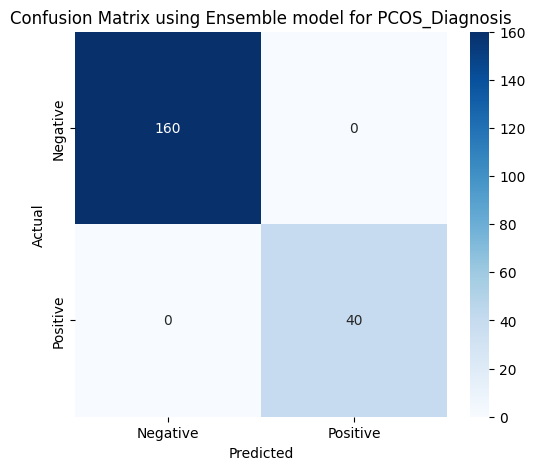

In [35]:
cm = confusion_matrix(y_test, y_pred_en)
# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix using Ensemble model for PCOS_Diagnosis")
plt.show()

In [36]:
print("Ensemble Model Classification Report:\n", classification_report(y_test, y_pred_en))

Ensemble Model Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       160
           1       1.00      1.00      1.00        40

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200

